# Pill Classification using mobile net 

In [1]:
## library  as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## library import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns


import numpy as np
import pandas as pd
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt


In [2]:
print(tf.__version__)
import tensorflow as tf
from tensorflow.python.client import device_lib

# 사용 가능한 디바이스 출력
print(device_lib.list_local_devices())


1.15.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18296400186801091367
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11425335906942129252
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7200896481460156535
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13756934999711582391
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2461713778801510926
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10820586701
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15940853319883138552
physical_device_desc: "device: 0, name: GeForce RTX 2080

### Dataset preparation

In [3]:
current_directory = os.getcwd()
print("현재 경로:", current_directory)

현재 경로: /data/seyoung_2024-2/PillClassification2/PillClassification


In [4]:
data_dir = 'train_raw'
train = 'train'
validation = 'validation'
test = 'test'

aug_data_dir = os.path.join(data_dir)
print(aug_data_dir)
image_dir = os.path.join(train, 'rectangle_img')
print(image_dir)
bbox_dir = os.path.join(train, 'rectangle_annotation')
print(bbox_dir)

val_img_dir = os.path.join(validation, 'rectangle_img')
val_bbox_dir = os.path.join(validation, 'rectangle_annotation')

test_img_dir = os.path.join(test, 'rectangle_img')
test_bbox_dir = os.path.join(test, 'rectangle_annotation')

train_raw
train/rectangle_img
train/rectangle_annotation


In [6]:
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

if not os.path.exists(bbox_dir):
    os.makedirs(bbox_dir)

if not os.path.exists(val_img_dir):
    os.makedirs(val_img_dir)

if not os.path.exists(val_bbox_dir):
    os.makedirs(val_bbox_dir)

if not os.path.exists(test_img_dir):
    os.makedirs(test_img_dir)

if not os.path.exists(test_bbox_dir):
    os.makedirs(test_bbox_dir)

In [7]:
# train set split
for file in os.listdir(aug_data_dir):
    file_format = re.split('[.]',file)[-1]
    if file_format=='jpg':
        shutil.copy(os.path.join(aug_data_dir, file), os.path.join(image_dir, file))
    else:
        shutil.copy(os.path.join(aug_data_dir, file), os.path.join(bbox_dir, file))

# validation set split
for file in os.listdir('validation_raw'):
    file_format = re.split('[.]',file)[-1]
    if file_format=='jpg':
        shutil.copy(os.path.join('validation_raw', file), os.path.join(val_img_dir, file))
    else:
        shutil.copy(os.path.join('validation_raw', file), os.path.join(val_bbox_dir, file))

# test set split
for file in os.listdir('test_raw'):
    file_format = re.split('[.]',file)[-1]
    if file_format=='jpg':
        shutil.copy(os.path.join('test_raw', file), os.path.join(test_img_dir, file))
    else:
        shutil.copy(os.path.join('test_raw', file), os.path.join(test_bbox_dir, file))

In [5]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))
image_files[:5]

80000


['LipinonTablet80mg(AtorvastatinCalciumTrihydrate)_1_augmented_image_1271.jpg',
 'SarvaltanTablet160mg(Valsartan)_0_augmented_image_481.jpg',
 'GasprenTablet(MosaprideCitrateDihydrate)_1_augmented_image_1426.jpg',
 'GasbetTablet5mg(MosaprideCitrateHydrate)_0_augmented_image_1139.jpg',
 'BalthrepTablet160mg(Valsartan)_0_augmented_image_1022.jpg']

In [7]:
# class수 확인
class_list = set()
for image_file in image_files:
    file_name = re.split('_',image_file)[0]
    class_list.add(file_name)

class_list = list(class_list)
print(len(class_list))

20


In [8]:
class_list.sort()
class_list[:5]

['ApurtranTablet150mg(Irbesartan)',
 'BalsanTablet80mg(Valsartan)',
 'BalthrepTablet160mg(Valsartan)',
 'DiosartanTablet160mg(Valsartan)',
 'EscitalTablet5mg(EscitalopramOxalate)']

In [9]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx['ApurtranTablet150mg(Irbesartan)']

0

In [10]:
train_images = os.listdir(image_dir)
val_images = os.listdir(val_img_dir)
test_images = os.listdir(test_img_dir)

print(len(train_images), len(val_images), len(test_images))

80000 8000 8000


In [11]:
train_images[:10]

['LipinonTablet80mg(AtorvastatinCalciumTrihydrate)_1_augmented_image_1271.jpg',
 'SarvaltanTablet160mg(Valsartan)_0_augmented_image_481.jpg',
 'GasprenTablet(MosaprideCitrateDihydrate)_1_augmented_image_1426.jpg',
 'GasbetTablet5mg(MosaprideCitrateHydrate)_0_augmented_image_1139.jpg',
 'BalthrepTablet160mg(Valsartan)_0_augmented_image_1022.jpg',
 'LipinonTablet80mg(AtorvastatinCalciumTrihydrate)_0_augmented_image_1406.jpg',
 'ValsartanTablet(Valsartan)_1_augmented_image_1397.jpg',
 'GasdialTablet50mg(DimethiconeMagnesium)_0_augmented_image_1386.jpg',
 'ValsartanTablet(Valsartan)_0_augmented_image_1133.jpg',
 'GasridTablet5mg(MosaprideCitrateHydrate)_1_augmented_image_727.jpg']

In [12]:
val_images[:10]

['DiosartanTablet160mg(Valsartan)_1_augmented_image_92.jpg',
 'ValsartanTablet(Valsartan)_1_augmented_image_49.jpg',
 'GasbetTablet5mg(MosaprideCitrateHydrate)_0_augmented_image_175.jpg',
 'GasridTablet5mg(MosaprideCitrateHydrate)_1_augmented_image_155.jpg',
 'BalthrepTablet160mg(Valsartan)_0_augmented_image_14.jpg',
 'ValsartanTablet(Valsartan)_1_augmented_image_133.jpg',
 'DiosartanTablet160mg(Valsartan)_1_augmented_image_42.jpg',
 'ValsartanTablet(Valsartan)_1_augmented_image_69.jpg',
 'ZolpidemSustainedReleaseTablet(ZolpidemTartrate)_1_augmented_image_31.jpg',
 'ValsartanTablet(Valsartan)_1_augmented_image_78.jpg']

In [13]:
train_dir = os.path.join('train/rectangle_img')
val_dir = os.path.join('validation/rectangle_img') 
test_dir = os.path.join('test/rectangle_img') 

### TFRecord

In [14]:
IMG_SIZE = 100

In [15]:

## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join('tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')
tfr_test_dir = os.path.join(tfr_dir, 'cls_test.tfr')

In [16]:
import tensorflow as tf
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)
writer_test = tf.io.TFRecordWriter(tfr_test_dir)

In [17]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.
# 데이터 직렬화

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [18]:
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(train_file)[0] #Bangal_101
  
  class_name = re.split('_',file_name)[0]
  class_num = class2idx[class_name]
  print(class_name)
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

LipinonTablet80mg(AtorvastatinCalciumTrihydrate)
SarvaltanTablet160mg(Valsartan)
GasprenTablet(MosaprideCitrateDihydrate)
GasbetTablet5mg(MosaprideCitrateHydrate)
BalthrepTablet160mg(Valsartan)
LipinonTablet80mg(AtorvastatinCalciumTrihydrate)
ValsartanTablet(Valsartan)
GasdialTablet50mg(DimethiconeMagnesium)
ValsartanTablet(Valsartan)
GasridTablet5mg(MosaprideCitrateHydrate)
ValsartelTablet80mg(Valsartan)
ValsartelTablet160mg(Valsartan)
ValsartelTablet160mg(Valsartan)
ExbanTablet80mg(Valsartan)
GasprenTablet(MosaprideCitrateDihydrate)
GasbetTablet5mg(MosaprideCitrateHydrate)
ExbanTablet80mg(Valsartan)
ValsartanTablet(Valsartan)
GasprenTablet(MosaprideCitrateDihydrate)
GasdialTablet50mg(DimethiconeMagnesium)
ValsartelTablet160mg(Valsartan)
RosorodTablet10mg(RosuvastatinCalcium)
DiosartanTablet160mg(Valsartan)
GasbetTablet5mg(MosaprideCitrateHydrate)
ValsartanTablet(Valsartan)
SarvaltanTablet160mg(Valsartan)
BalsanTablet80mg(Valsartan)
GasbetTablet5mg(MosaprideCitrateHydrate)
NumentaminS

In [19]:
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(val_file)[0] #Bangal_101
  class_name = re.split('_',file_name)[0]
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print(n_val)

8000


In [20]:
n_test = 0

test_files = os.listdir(test_dir)
for test_file in test_files:
  test_path = os.path.join(test_dir, test_file)
  image = Image.open(test_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(test_file)[0] #Bangal_101
  class_name = re.split('_',file_name)[0]
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_test.write(example.SerializeToString())
  n_test += 1

writer_test.close()
print(n_test)

8000


### Classification

In [21]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 10
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 100
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH#STEPS_PER_EPOCH =n_train//batch_size # len(train_data) // batch_size
validation_steps = int(np.ceil(N_VAL / N_BATCH))#VALIDATION_STEPS = n_val//batch_size # len(valid_data) // batch_size

In [22]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    label = tf.one_hot(label, N_CLASS)

    return image, label

In [23]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [24]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [25]:
## test dataset 만들기
test_dataset = tf.data.TFRecordDataset(tfr_test_dir)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(N_BATCH).repeat()

In [31]:
for image, label in train_dataset.take(1):
  for i in range(N_BATCH):    
#     print(label[i].numpy())
    plt.imshow(image[i])
    plt.show()

RuntimeError: __iter__() is only supported inside of tf.function or when eager execution is enabled.

In [27]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [61]:
from keras import models
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# from keras.applications import MobileNetV2
# import h5py

# # HDF5 파일을 열 때 decode를 사용하지 않도록 설정
# def no_decode(file):
#     def dummy_decode(x):
#         return x
#     file.attrs['keras_version'] = dummy_decode(file.attrs['keras_version'])
#     file.attrs['backend'] = dummy_decode(file.attrs['backend'])
#     file.attrs['model_config'] = dummy_decode(file.attrs['model_config'])

# h5py.File = no_decode

# # 모델 로드
# mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))




In [60]:
# import h5py

# # h5py의 decode 함수를 우회하는 패치
# original_keras_version = h5py.version.hdf5_version_tuple

# def patched_decode(x):
#     try:
#         return x.decode('utf-8')
#     except (AttributeError, UnicodeDecodeError):
#         return x

# h5py.Dataset.decode = patched_decode


In [28]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/ai/anaconda3/envs/pill_detection2/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [29]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [30]:
def create_mv_model():
    # 새로운 모델 생성하기
    last = mobilenetv2.output
    x = GlobalAveragePooling2D()(last)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    pred = Dense(N_CLASS, activation='softmax')(x)
    
    model = Model(mobilenetv2.input, pred)
    model.summary
    return model

In [31]:
## Create model, compile & summary
model = create_mv_model()

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
  if epoch < RAMPUP_EPOCH:
    lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
  else:
    lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
  return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

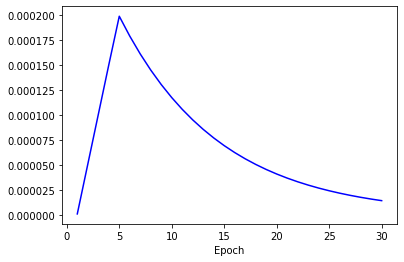

In [32]:
def plot_lr():
  lr = []
  epoch_list = list(np.arange(N_EPOCHS) + 1)
  for epoch in range(N_EPOCHS):
    lr.append(lr_schedule_fn(epoch))    
  plt.plot(epoch_list, lr, 'b-')
  plt.xlabel('Epoch')
  plt.show()

plot_lr()

In [33]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

AttributeError: module 'tensorflow._api.v1.config' has no attribute 'list_physical_devices'

In [34]:
!nvidia-smi

Mon Oct  7 19:07:17 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 27%   40C    P8    21W / 250W |  10597MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:67:00.0 Off |                  N/A |
| 27%   

In [35]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Train on 2000.0 steps, validate on 200 steps
Epoch 1/30
2000/2000 [==============================] - 125s 63ms/step - loss: 2.3323 - acc: 0.3795 - val_loss: 1.7439 - val_acc: 0.6169
Epoch 2/30
2000/2000 [==============================] - 113s 57ms/step - loss: 0.6883 - acc: 0.9879 - val_loss: 0.6202 - val_acc: 0.9996
Epoch 3/30
2000/2000 [==============================] - 114s 57ms/step - loss: 0.6117 - acc: 0.9995 - val_loss: 0.5995 - val_acc: 1.0000
Epoch 4/30
2000/2000 [==============================] - 113s 57ms/step - loss: 0.6042 - acc: 0.9987 - val_loss: 0.6010 - val_acc: 0.9996
Epoch 5/30
2000/2000 [==============================] - 113s 56ms/step - loss: 0.6036 - acc: 0.9982 - val_loss: 0.5974 - val_acc: 0.9998
Epoch 6/30
2000/2000 [==============================] - 114s 57ms/step - loss: 0.5984 - acc: 0.9995 - val_loss: 0.5961 - val_acc: 1.0000
Epoch 7/30
2000/2000 [==============================] - 114s 57ms/step - loss: 0.5971 - acc: 0.9997 - val_loss: 0.5946 - val_acc: 1.0

KeyboardInterrupt: 